**Create a model to algorithmically predict if a review is positive or negative just based on its text.**
- http://jmcauley.ucsd.edu/data/amazon/

In [1]:
import gzip
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import string
import nltk
from textblob import TextBlob
import numpy as np

# Importing Data

In [2]:
# parsing from .zip files

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = getDF('datasets/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


**Reviewing the data**

In [4]:
df.shape

(278677, 9)

In [5]:
df.isnull().sum()

reviewerID          0
asin                0
reviewerName      452
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

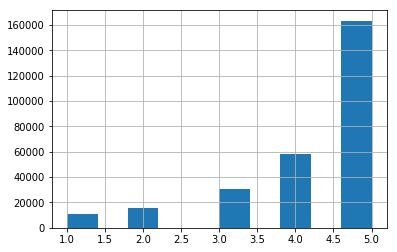

In [6]:
df.overall.hist()

In [7]:
# Describing target data

df['overall'].value_counts()

5.0    163240
4.0     58357
3.0     30425
2.0     15463
1.0     11192
Name: overall, dtype: int64

**Creating feature set with randomized data subset for computational workload reduction**

In [8]:
df = df.sample(frac=0.25)
features = df[['reviewerID', 'reviewText', 'summary', 'overall']]

In [9]:
features.head()

,reviewerID,reviewText,summary,overall
134605,A2NDA5EJ22W4B,These arrived quickly and looked just like the...,Looks just like the picture,2.0
265513,A19HJ0A46JBRWH,"They are warm, tight fit, ship quickly, no sho...",Perfect leggings,5.0
273203,A2YP323KXIBPQ9,I bought this shirt to sleep in. Looking at t...,Not as long as in pic,2.0
33995,A1Z13WY11V4SQ,I live in NH and walk my dogs in the wind and ...,Very Useful,5.0
233966,A2VWASAGNCY16L,A better universal fit for the non model body ...,Nice cut and fit,4.0


In [10]:
df.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object

# Sentiment Ratings

In [11]:
# --sentiment--

# reviewText sentiment

reviewText_sentiment_list = list(features['reviewText'])
reviewText_sentiment_column = []

for i in reviewText_sentiment_list:
    reviewText_sentiment_column.append(TextBlob(i).sentiment.polarity)
    
features['reviewText_sentiment'] = reviewText_sentiment_column

# summary sentiment

summary_sentiment_list = list(features['summary'])
summary_sentiment_column = []

for j in summary_sentiment_list:
    summary_sentiment_column.append(TextBlob(j).sentiment.polarity)
    
features['summary_sentiment'] = summary_sentiment_column

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Term Counts

**Importing positive and negative lists**

In [12]:
positive_terms = pd.read_csv('datasets/keywords_pos.csv', header=None)
negative_terms = pd.read_csv('datasets/keywords_neg.csv', header=None)

In [13]:
negative_terms[0].head()

0       2-faced
1       2-faces
2      abnormal
3       abolish
4    abominable
Name: 0, dtype: object

In [14]:
positive_terms = positive_terms[0].tolist()
negative_terms = negative_terms[0].tolist()

**Preparing text for term count**

In [15]:
# Columns to lowercase strings

all_review_text = features['reviewText'].str.lower()
all_summary_text = features['summary'].str.lower()

# Strings to arrays

all_review_text = all_review_text.tolist()
all_summary_text = all_summary_text.tolist()

# Tokenizing

all_review_text_break = [nltk.tokenize.wordpunct_tokenize(text) for text in all_review_text]
all_summary_text_break = [nltk.tokenize.wordpunct_tokenize(text) for text in all_summary_text]

In [16]:
# Flatten the list of lists from dataframe

all_review_text_break = [item for sublist in all_review_text_break for item in sublist]
all_summary_text_break = [item for sublist in all_summary_text_break for item in sublist]

In [17]:
all_review_text_break[40:46]

[',', 'and', 'make', 'my', 'legs', 'look']

In [18]:
stopwords = nltk.corpus.stopwords.words('english')

# reviewText

all_review_text_clean = []

for w in all_review_text_break:
    if w not in stopwords:
        all_review_text_clean.append(w)
        
# summary text
    
all_summary_text_clean = []

for w in all_summary_text_break:
    if w not in stopwords:
        all_summary_text_clean.append(w)

In [19]:
all_review_text_clean[40:46]

['pic', ',', 'looks', 'extra', 'long', '.']

**Counting words**

In [20]:
# Function that counts the number of times each word appeared in the sentiment lists

# reviewText

most_common_reviewText_pos = {}

for i in positive_terms:
    most_common_reviewText_pos[i] = all_review_text_clean.count(i)

most_common_reviewText_neg = {}

for j in negative_terms:
    most_common_reviewText_neg[j] = all_review_text_clean.count(j)
    
# summary text

most_common_summary_pos = {}

for i in positive_terms:
    most_common_summary_pos[i] = all_summary_text_clean.count(i)

most_common_summary_neg = {}

for j in negative_terms:
    most_common_summary_neg[j] = all_summary_text_clean.count(j)

In [21]:
# Slicing the top 10 most counted terms in the reviewText and summary

# reviewText

pos = Counter(most_common_reviewText_pos)
pos.most_common()

pos_reviewText_list = []

for k, v in pos.most_common(10):
    pos_reviewText_list.append(k)

neg_reviewText_list = []

neg = Counter(most_common_reviewText_neg)
neg.most_common()

for k, v in neg.most_common(10):
    neg_reviewText_list.append(k) 
    
# summary text

pos = Counter(most_common_summary_pos)
pos.most_common()

pos_summary_list = []

for k, v in pos.most_common(10):
    pos_summary_list.append(k)

neg_summary_list = []

neg = Counter(most_common_summary_neg)
neg.most_common()

for k, v in neg.most_common(10):
    neg_summary_list.append(k) 

In [22]:
pos_reviewText_list

['like',
 'great',
 'good',
 'well',
 'love',
 'comfortable',
 'nice',
 'perfect',
 'recommend',
 'work']

In [23]:
# Creating columns of formerly cleaned data to search for words in each record and create a term count feature

features['reviewText'] = [nltk.tokenize.wordpunct_tokenize(text) for text in all_review_text]
features['summary'] = [nltk.tokenize.wordpunct_tokenize(text) for text in all_summary_text]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
features.head()

,reviewerID,reviewText,summary,overall,reviewText_sentiment,summary_sentiment
134605,A2NDA5EJ22W4B,"[these, arrived, quickly, and, looked, just, l...","[looks, just, like, the, picture]",2.0,-0.003333,0.00
265513,A19HJ0A46JBRWH,"[they, are, warm, ,, tight, fit, ,, ship, quic...","[perfect, leggings]",5.0,0.309127,1.00
273203,A2YP323KXIBPQ9,"[i, bought, this, shirt, to, sleep, in, ., loo...","[not, as, long, as, in, pic]",2.0,-0.074444,-0.05
33995,A1Z13WY11V4SQ,"[i, live, in, nh, and, walk, my, dogs, in, the...","[very, useful]",5.0,0.090130,0.39
233966,A2VWASAGNCY16L,"[a, better, universal, fit, for, the, non, mod...","[nice, cut, and, fit]",4.0,0.375000,0.50


**Creating columns with word counts**

In [25]:
def count_words(word_list,column):
    new_column = 0
    for word in word_list:
        new_column = column.apply(lambda x: x.count(word))
    return new_column

# reviewText

features['pos_reviewText_count'] = count_words(pos_reviewText_list,features['reviewText'])
features['neg_reviewText_count'] = count_words(neg_reviewText_list, features['reviewText'])

# summary

features['pos_summary_count'] = count_words(pos_summary_list, features['summary'])
features['neg_summary_count'] = count_words(neg_summary_list, features['summary'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [26]:
# Separating negative sentiment from positive and averaging term count across all text for context

# reviewText

features['pos_reviewText_count'] = features['pos_reviewText_count'] / features['pos_reviewText_count'].sum()
features['neg_reviewText_count'] = features['neg_reviewText_count'] * -1 / features['neg_reviewText_count'].sum()

# summary

features['pos_summary_count'] = features['pos_summary_count'] / features['pos_summary_count'].sum()
features['neg_summary_count'] = features['neg_summary_count'] * -1 / features['neg_summary_count'].sum()

In [27]:
features[features['pos_reviewText_count'] > .001].head()

,reviewerID,reviewText,summary,overall,reviewText_sentiment,summary_sentiment,pos_reviewText_count,neg_reviewText_count,pos_summary_count,neg_summary_count
87727,A1H4R7TY2G50DH,"[i, paid, $, 9, ., 45everything, works, and, e...","[good, for, price]",5.0,0.175901,0.700000,0.001046,0.00000,0.0,0.0
117974,A2WVX35E4263BR,"[i, ordered, the, black, 8, petite, ,, i, am, ...","[dressy, but, comfortable, for, work, &, runni...",4.0,0.295767,0.400000,0.001046,0.00000,0.0,0.0
47802,AFHYEO3Y1IIDD,"[campaign, :, one, for, one, ., for, every, pa...","[disposable, shoes, -, but, good, intentions, ...",2.0,0.160194,0.350000,0.001046,0.00000,0.0,0.0
4746,A9RTRKZM3IEOY,"[i, am, a, contractor, and, i, use, these, sho...","[tough, work, shorts, !]",5.0,0.113000,-0.486111,0.001046,-0.00084,0.0,0.0
175344,AJTI9FHNONU8Y,"[i, would, not, choose, these, as, running, sh...","[great, looking, and, i, get, compliments, all...",4.0,0.266038,0.800000,0.001221,0.00000,0.0,0.0


+ **Some reviews are not in english. Translation with googletrans is not feasible even with reinitializing the API with each 15k cap. Non-english text will continue to affect the performance of the model(s) unless it can be removed or translated**

# Preparing target data for modeling

**Transforming target variable for predicting a perfect 5 score**

In [28]:
features['overall_bin'] = 0
features.loc[(features['overall'] > 4), 'overall_bin'] = 1

# Running and tuning models

**Naive Bayes**

In [29]:
data = features[['reviewText_sentiment', 'summary_sentiment', 'pos_reviewText_count', 'neg_reviewText_count', 'pos_summary_count', 'neg_summary_count']]
target = features['overall_bin']

# Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 69669 points : 25298


**Random Forest Classifier**

In [30]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=350)

X = features[['reviewText_sentiment', 'summary_sentiment', 'pos_reviewText_count', 'neg_reviewText_count', 'pos_summary_count', 'neg_summary_count']]
Y = features['overall_bin']

score = cross_val_score(rfc, X, Y, cv=10)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.66360505 0.6608783  0.66173938 0.66733639 0.66054256 0.65733563
 0.65360322 0.65877117 0.65633075 0.66078094]
Accuracy: 0.66 (+/- 0.01)


# Does a review classification model for one category work for another?

In [31]:
df_clothing = getDF('datasets/reviews_Video_Games_5.json.gz')

In [32]:
df_clothing = df_clothing.sample(frac=0.25)
features = df_clothing[['reviewerID', 'reviewText', 'summary', 'overall']]

# Sentiment Ratings

In [33]:
# --sentiment--

# reviewText sentiment

reviewText_sentiment_list = list(features['reviewText'])
reviewText_sentiment_column = []

for i in reviewText_sentiment_list:
    reviewText_sentiment_column.append(TextBlob(i).sentiment.polarity)
    
features['reviewText_sentiment'] = reviewText_sentiment_column

# summary sentiment

summary_sentiment_list = list(features['summary'])
summary_sentiment_column = []

for j in summary_sentiment_list:
    summary_sentiment_column.append(TextBlob(j).sentiment.polarity)
    
features['summary_sentiment'] = summary_sentiment_column

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Term Counts

**Preparing text for term count**

In [34]:
# Columns to lowercase strings

all_review_text = features['reviewText'].str.lower()
all_summary_text = features['summary'].str.lower()

# Strings to arrays

all_review_text = all_review_text.tolist()
all_summary_text = all_summary_text.tolist()

# Tokenizing

all_review_text_break = [nltk.tokenize.wordpunct_tokenize(text) for text in all_review_text]
all_summary_text_break = [nltk.tokenize.wordpunct_tokenize(text) for text in all_summary_text]

In [35]:
# Flatten the list of lists from dataframe

all_review_text_break = [item for sublist in all_review_text_break for item in sublist]
all_summary_text_break = [item for sublist in all_summary_text_break for item in sublist]

In [36]:
stopwords = nltk.corpus.stopwords.words('english')

# reviewText

all_review_text_clean = []

for w in all_review_text_break:
    if w not in stopwords:
        all_review_text_clean.append(w)
        
# summary text
    
all_summary_text_clean = []

for w in all_summary_text_break:
    if w not in stopwords:
        all_summary_text_clean.append(w)

**Counting words**

In [37]:
# Function that counts the number of times each word appeared in the sentiment lists

# reviewText

most_common_reviewText_pos = {}

for i in positive_terms:
    most_common_reviewText_pos[i] = all_review_text_clean.count(i)

most_common_reviewText_neg = {}

for j in negative_terms:
    most_common_reviewText_neg[j] = all_review_text_clean.count(j)
    
# summary text

most_common_summary_pos = {}

for i in positive_terms:
    most_common_summary_pos[i] = all_summary_text_clean.count(i)

most_common_summary_neg = {}

for j in negative_terms:
    most_common_summary_neg[j] = all_summary_text_clean.count(j)

In [38]:
# Slicing the top 10 most counted terms in the reviewText and summary

# reviewText

pos = Counter(most_common_reviewText_pos)
pos.most_common()

pos_reviewText_list = []

for k, v in pos.most_common(10):
    pos_reviewText_list.append(k)

neg_reviewText_list = []

neg = Counter(most_common_reviewText_neg)
neg.most_common()

for k, v in neg.most_common(10):
    neg_reviewText_list.append(k) 
    
# summary text

pos = Counter(most_common_summary_pos)
pos.most_common()

pos_summary_list = []

for k, v in pos.most_common(10):
    pos_summary_list.append(k)

neg_summary_list = []

neg = Counter(most_common_summary_neg)
neg.most_common()

for k, v in neg.most_common(10):
    neg_summary_list.append(k) 

In [39]:
# Creating columns of formerly cleaned data to search for words in each record and create a term count feature

features['reviewText'] = [nltk.tokenize.wordpunct_tokenize(text) for text in all_review_text]
features['summary'] = [nltk.tokenize.wordpunct_tokenize(text) for text in all_summary_text]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


**Creating columns with word counts**

In [40]:
def count_words(word_list,column):
    new_column = 0
    for word in word_list:
        new_column = column.apply(lambda x: x.count(word))
    return new_column

# reviewText

features['pos_reviewText_count'] = count_words(pos_reviewText_list,features['reviewText'])
features['neg_reviewText_count'] = count_words(neg_reviewText_list, features['reviewText'])

# summary

features['pos_summary_count'] = count_words(pos_summary_list, features['summary'])
features['neg_summary_count'] = count_words(neg_summary_list, features['summary'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [41]:
# Separating negative sentiment from positive and averaging term count across all text for context

# reviewText

features['pos_reviewText_count'] = features['pos_reviewText_count'] / features['pos_reviewText_count'].sum()
features['neg_reviewText_count'] = features['neg_reviewText_count'] * -1 / features['neg_reviewText_count'].sum()

# summary

features['pos_summary_count'] = features['pos_summary_count'] / features['pos_summary_count'].sum()
features['neg_summary_count'] = features['neg_summary_count'] * -1 / features['neg_summary_count'].sum()

# Preparing target data for modeling

In [43]:
features['overall_bin'] = 0
features.loc[(features['overall'] > 4), 'overall_bin'] = 1

# Running and tuning models

**Naive Bayes**

In [44]:
data = features[['reviewText_sentiment', 'summary_sentiment', 'pos_reviewText_count', 'neg_reviewText_count', 'pos_summary_count', 'neg_summary_count']]
target = features['overall_bin']

# Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 57945 points : 23755


**Random Forest Classifier**

In [45]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=350)

X = features[['reviewText_sentiment', 'summary_sentiment', 'pos_reviewText_count', 'neg_reviewText_count', 'pos_summary_count', 'neg_summary_count']]
Y = features['overall_bin']

score = cross_val_score(rfc, X, Y, cv=10)
print(score)
print('Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

[0.60569456 0.60448663 0.60103538 0.59792925 0.60431406 0.60120794
 0.60510873 0.60269244 0.60424577 0.60227861]
Accuracy: 0.60 (+/- 0.00)
